## Import relevant modules

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('data/health_records.csv')
df.head()

/var/folders/s5/9tx92s6n1r1g20vf5q0j7gxc0000gp/T/ipykernel_90030/2512358272.py:1: DtypeWarning: Columns (1,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/health_records.csv')


,type,value,unit,sourceName,sourceVersion,device,creationDate,startDate,endDate
0,HKQuantityTypeIdentifierDietaryWater,709.765,mL,Sync Solver,25,NaN,2016-06-20 13:52:52 -0400,2015-07-17 00:00:00 -0400,2015-07-17 23:59:59 -0400
1,HKQuantityTypeIdentifierBodyMassIndex,23.5981,count,Sync Solver,NaN,NaN,2015-04-19 09:42:10 -0400,2015-01-17 01:00:00 -0400,2015-01-18 00:59:59 -0400
2,HKQuantityTypeIdentifierBodyMassIndex,23.5981,count,Sync Solver,NaN,NaN,2015-04-19 09:42:10 -0400,2013-08-18 00:00:00 -0400,2013-08-18 23:59:59 -0400
3,HKQuantityTypeIdentifierBodyMassIndex,23.5981,count,Sync Solver,NaN,NaN,2015-04-19 09:42:10 -0400,2013-05-19 00:00:00 -0400,2013-05-19 23:59:59 -0400
4,HKQuantityTypeIdentifierBodyMassIndex,23.5981,count,Sync Solver,NaN,NaN,2015-04-19 09:42:10 -0400,2013-04-25 00:00:00 -0400,2013-04-25 23:59:59 -0400


## Show all the different device names

In [4]:
for val, count in df.sourceName.value_counts().items():
    print(repr(val), count)

'Rob’s Apple\xa0Watch' 2297164
'Rob’s iPhone' 288520
'Robs iPhone' 117846
'Polar Flow' 71560
'Sync Solver' 17322
'Strava' 1197
'iPhone' 1055
'Health' 403
'Blood Oxygen' 10
'Sleep' 1


In [5]:
df.type.value_counts()

type
HKQuantityTypeIdentifierActiveEnergyBurned                853486
HKQuantityTypeIdentifierHeartRate                         411634
HKQuantityTypeIdentifierBasalEnergyBurned                 297838
HKQuantityTypeIdentifierDistanceWalkingRunning            291024
HKQuantityTypeIdentifierStepCount                         249130
HKQuantityTypeIdentifierRunningSpeed                       80848
HKQuantityTypeIdentifierAppleExerciseTime                  73715
HKQuantityTypeIdentifierRunningPower                       68738
HKQuantityTypeIdentifierAppleStandTime                     45524
HKQuantityTypeIdentifierFlightsClimbed                     44125
HKQuantityTypeIdentifierWalkingStepLength                  41021
HKQuantityTypeIdentifierWalkingSpeed                       41016
HKQuantityTypeIdentifierEnvironmentalAudioExposure         40515
HKQuantityTypeIdentifierRunningVerticalOscillation         33382
HKQuantityTypeIdentifierRunningStrideLength                31271
HKQuantityTypeIdenti

In [6]:
device_df = df[df.sourceName == 'Rob’s Apple\xa0Watch'].copy()

def remove_tz_info(series: pd.Series) -> pd.Series:
    """
    Corrects HealthKit timestamps by stripping unreliable offsets.
    
    Args:
        series: The pandas Series containing timestamp strings.
        
    Returns:
        pd.Series: A timezone-naive datetime series with correct historical offsets.
    """
    # Convert to datetime objects first
    datetimes = pd.to_datetime(series)
    
    # Strip the unreliable offset (naive time)
    naive_datetimes = datetimes.dt.tz_localize(None)
    
    return naive_datetimes

# Apply the correction to all timestamp columns
device_df['creationDate'] = remove_tz_info(device_df['creationDate'])
device_df['startDate'] = remove_tz_info(device_df['startDate'])
device_df['endDate'] = remove_tz_info(device_df['endDate'])

# Filter rows where the time difference between endDate and startDate is more than 1 hour
delta = device_df['endDate'] - device_df['startDate']
device_df = device_df[delta <= pd.Timedelta(hours=1)]


device_df.index = device_df.startDate

In [7]:
device_df.type.value_counts()[:10]

type
HKQuantityTypeIdentifierActiveEnergyBurned            852325
HKQuantityTypeIdentifierHeartRate                     340073
HKQuantityTypeIdentifierBasalEnergyBurned             294494
HKQuantityTypeIdentifierDistanceWalkingRunning        182583
HKQuantityTypeIdentifierStepCount                     148113
HKQuantityTypeIdentifierRunningSpeed                   80848
HKQuantityTypeIdentifierRunningPower                   68738
HKQuantityTypeIdentifierAppleExerciseTime              53389
HKQuantityTypeIdentifierEnvironmentalAudioExposure     40515
HKQuantityTypeIdentifierAppleStandTime                 40344
Name: count, dtype: int64

<Axes: xlabel='startDate'>

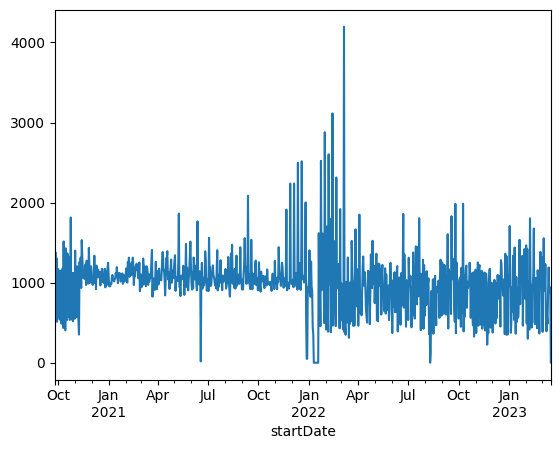

In [8]:
device_df[device_df.type == 'HKQuantityTypeIdentifierActiveEnergyBurned'].value.resample("d").sum().plot()

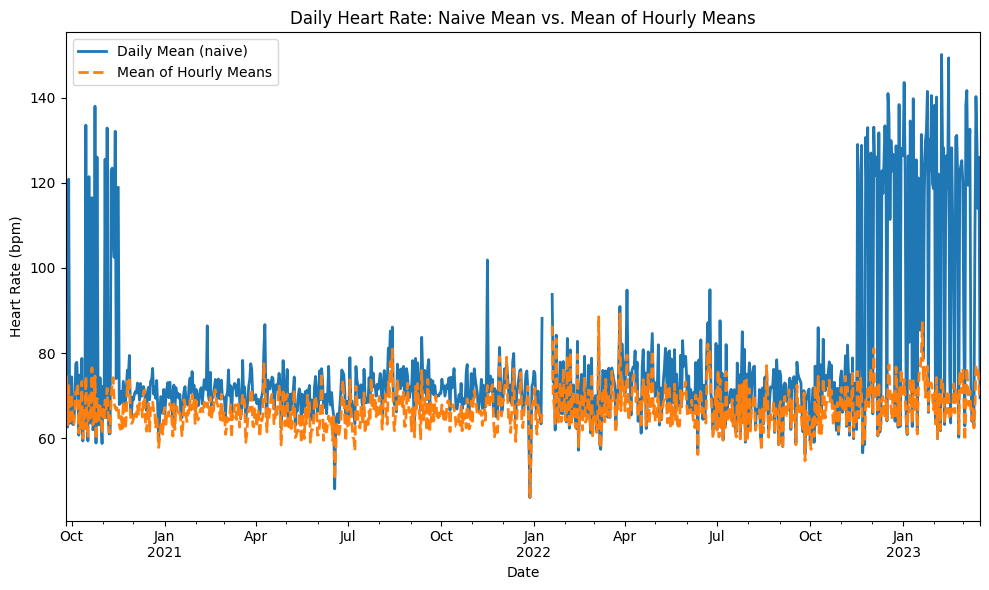

In [34]:
import matplotlib.pyplot as plt

heart_rate_daily_naive = device_df[device_df.type == 'HKQuantityTypeIdentifierHeartRate'].value.resample('d').mean()
heart_rate_daily = device_df[device_df.type == 'HKQuantityTypeIdentifierHeartRate'].value.resample('1h').mean().resample('d').mean()

plt.figure(figsize=(10, 6))
heart_rate_daily_naive.plot(label='Daily Mean (naive)', linewidth=2)
heart_rate_daily.plot(label='Mean of Hourly Means', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.title('Daily Heart Rate: Naive Mean vs. Mean of Hourly Means')
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
# Define metrics and their aggregation methods (sum for cumulative, mean for rates)
metrics_config = {
    'HKQuantityTypeIdentifierActiveEnergyBurned': 'sum',
    'HKQuantityTypeIdentifierHeartRate': 'mean',
    'HKQuantityTypeIdentifierBasalEnergyBurned': 'sum',
    'HKQuantityTypeIdentifierDistanceWalkingRunning': 'sum',
    'HKQuantityTypeIdentifierStepCount': 'sum',
    'HKQuantityTypeIdentifierRunningSpeed': 'mean',
    'HKQuantityTypeIdentifierRunningPower': 'mean',
    'HKQuantityTypeIdentifierAppleExerciseTime': 'sum',
    'HKQuantityTypeIdentifierEnvironmentalAudioExposure': 'mean',
    'HKQuantityTypeIdentifierAppleStandTime': 'sum',
}

# Build daily DataFrame
daily_data = {}
for metric, agg_method in metrics_config.items():
    subset = pd.to_numeric(device_df[device_df.type == metric]['value'], errors='coerce')
    if agg_method == 'sum':
        daily_data[metric] = subset.resample('D').sum()
    else:
        daily_data[metric] = subset.resample('D').mean()

daily_df = pd.DataFrame(daily_data)
daily_df

,HKQuantityTypeIdentifierActiveEnergyBurned,HKQuantityTypeIdentifierHeartRate,HKQuantityTypeIdentifierBasalEnergyBurned,HKQuantityTypeIdentifierDistanceWalkingRunning,HKQuantityTypeIdentifierStepCount,HKQuantityTypeIdentifierRunningSpeed,HKQuantityTypeIdentifierRunningPower,HKQuantityTypeIdentifierAppleExerciseTime,HKQuantityTypeIdentifierEnvironmentalAudioExposure,HKQuantityTypeIdentifierAppleStandTime
startDate,,,,,,,,,,
2020-09-25 00:00:00-04:00,142.219,63.333563,469.737,0.364686,750.0,NaN,NaN,1.0,NaN,26.0
2020-09-26 00:00:00-04:00,1380.714,96.925524,2195.694,6.068189,12284.0,NaN,NaN,105.0,71.283803,241.0
2020-09-27 00:00:00-04:00,784.015,62.674077,2217.154,4.012871,8057.0,NaN,NaN,59.0,61.727400,119.0
2020-09-28 00:00:00-04:00,1304.451,120.857667,2270.105,8.154036,13561.0,NaN,NaN,72.0,59.369372,151.0
2020-09-29 00:00:00-04:00,511.712,63.534644,2165.280,2.031652,4207.0,NaN,NaN,25.0,61.768209,56.0
...,...,...,...,...,...,...,...,...,...,...
2023-03-14 00:00:00-04:00,1189.286,140.239636,2183.173,7.128178,10646.0,6.082471,304.499507,77.0,58.649826,93.0
2023-03-15 00:00:00-04:00,880.621,129.186419,2137.165,5.218264,7519.0,6.223436,286.635417,50.0,64.606065,65.0
2023-03-16 00:00:00-04:00,932.166,113.961841,2256.459,4.755769,6705.0,6.422770,288.959158,51.0,57.778634,54.0


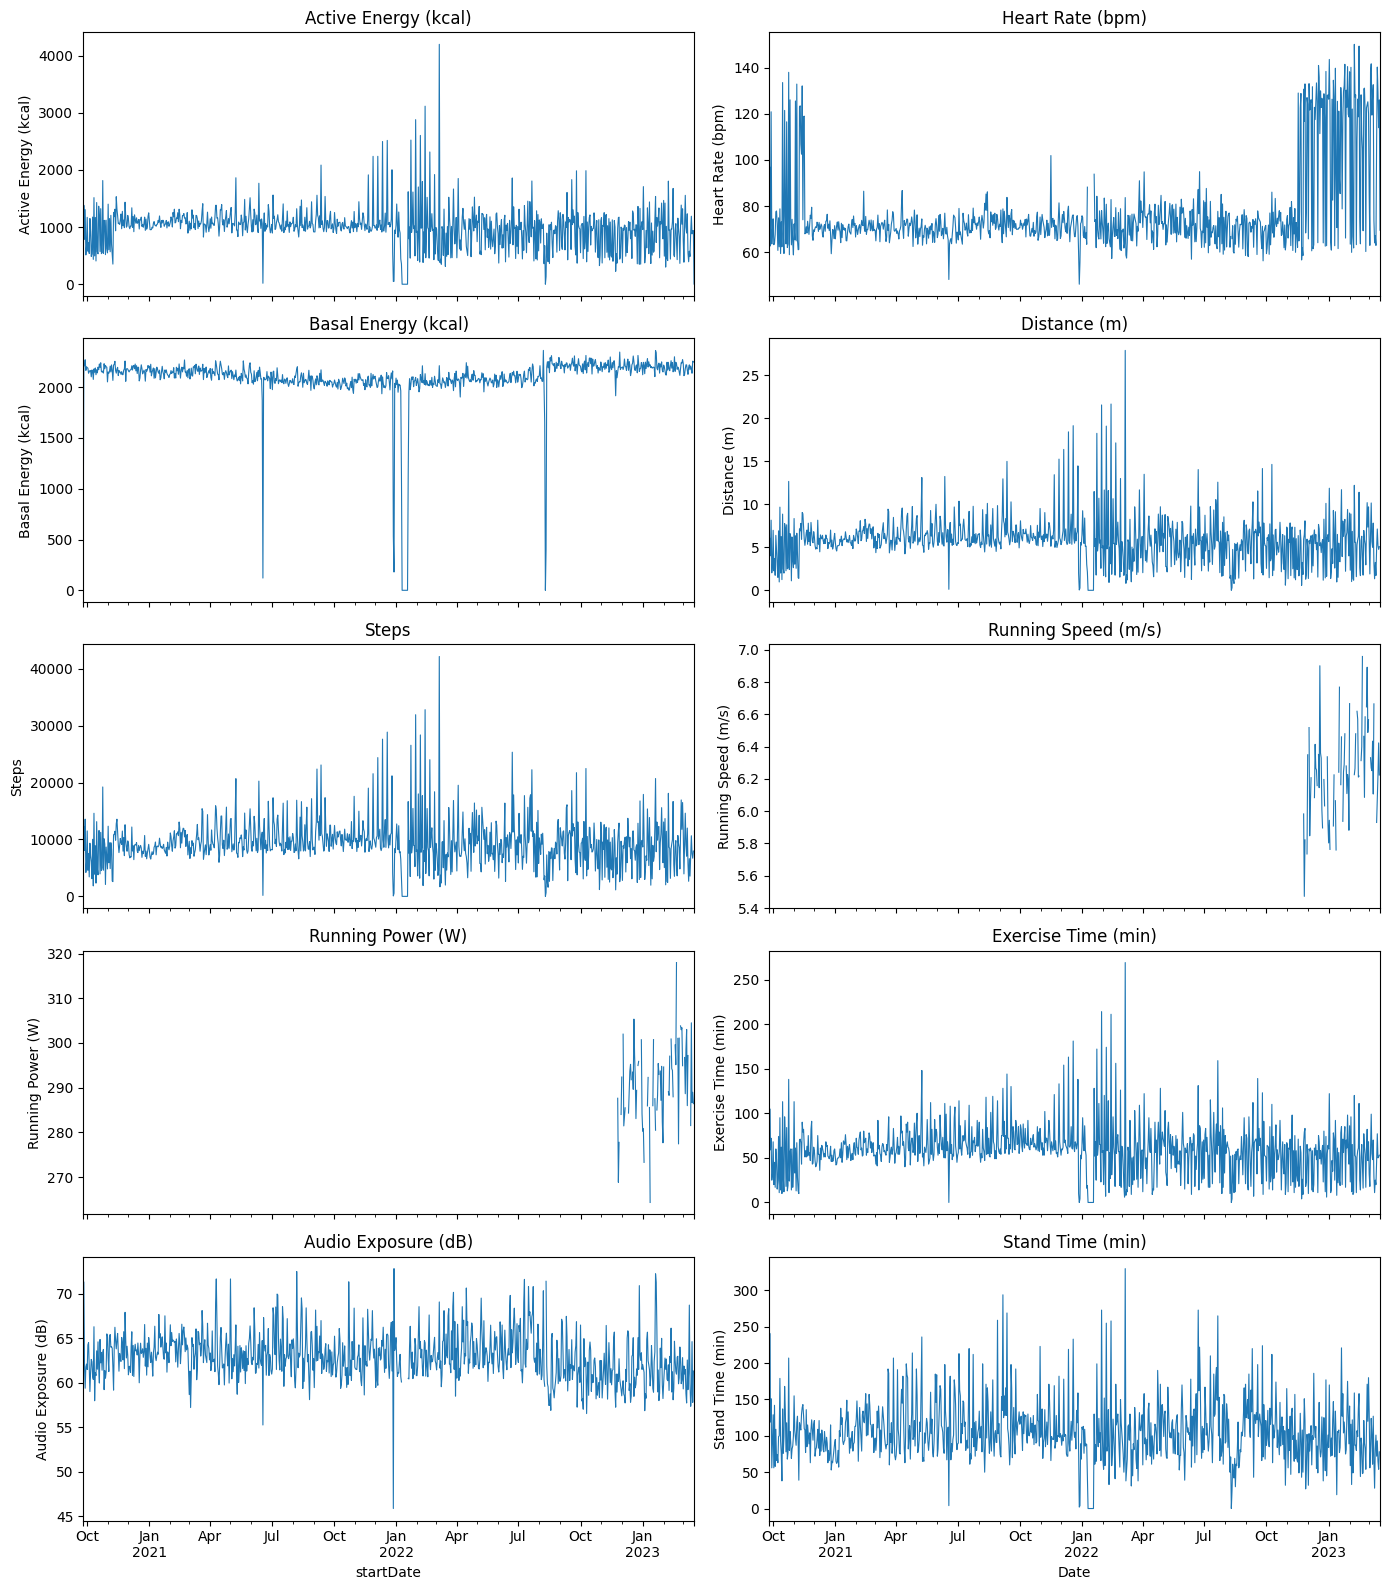

In [50]:


# Create a 5x2 subplot grid with shared x-axis
fig, axes = plt.subplots(5, 2, figsize=(14, 16), sharex=True)
axes = axes.flatten()

# Shorter labels for readability
short_names = {
    'HKQuantityTypeIdentifierActiveEnergyBurned': 'Active Energy (kcal)',
    'HKQuantityTypeIdentifierHeartRate': 'Heart Rate (bpm)',
    'HKQuantityTypeIdentifierBasalEnergyBurned': 'Basal Energy (kcal)',
    'HKQuantityTypeIdentifierDistanceWalkingRunning': 'Distance (m)',
    'HKQuantityTypeIdentifierStepCount': 'Steps',
    'HKQuantityTypeIdentifierRunningSpeed': 'Running Speed (m/s)',
    'HKQuantityTypeIdentifierRunningPower': 'Running Power (W)',
    'HKQuantityTypeIdentifierAppleExerciseTime': 'Exercise Time (min)',
    'HKQuantityTypeIdentifierEnvironmentalAudioExposure': 'Audio Exposure (dB)',
    'HKQuantityTypeIdentifierAppleStandTime': 'Stand Time (min)',
}

for i, col in enumerate(daily_df.columns):
    ax = axes[i]
    daily_df[col].plot(ax=ax, linewidth=0.8)
    ax.set_ylabel(short_names.get(col, col.split('Identifier')[-1]))
    ax.set_title(short_names.get(col, col.split('Identifier')[-1]))

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [ ]:
# Basic outlier detection using 2.5 IQR as the threshold (people often use 1.5 IQR)
Q1 = daily_df.quantile(0.25)
Q3 = daily_df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

# Replace outliers with NaN
daily_df = daily_df.mask((daily_df < lower_bound) | (daily_df > upper_bound))
daily_df

,HKQuantityTypeIdentifierActiveEnergyBurned,HKQuantityTypeIdentifierHeartRate,HKQuantityTypeIdentifierBasalEnergyBurned,HKQuantityTypeIdentifierDistanceWalkingRunning,HKQuantityTypeIdentifierStepCount,HKQuantityTypeIdentifierRunningSpeed,HKQuantityTypeIdentifierRunningPower,HKQuantityTypeIdentifierAppleExerciseTime,HKQuantityTypeIdentifierEnvironmentalAudioExposure,HKQuantityTypeIdentifierAppleStandTime
startDate,,,,,,,,,,
2020-09-25 00:00:00-04:00,NaN,63.333563,NaN,0.364686,750.0,NaN,NaN,1.0,NaN,26.0
2020-09-26 00:00:00-04:00,1380.714,NaN,2195.694,6.068189,12284.0,NaN,NaN,105.0,71.283803,241.0
2020-09-27 00:00:00-04:00,784.015,62.674077,2217.154,4.012871,8057.0,NaN,NaN,59.0,61.727400,119.0
2020-09-28 00:00:00-04:00,1304.451,NaN,2270.105,8.154036,13561.0,NaN,NaN,72.0,59.369372,151.0
2020-09-29 00:00:00-04:00,511.712,63.534644,2165.280,2.031652,4207.0,NaN,NaN,25.0,61.768209,56.0
...,...,...,...,...,...,...,...,...,...,...
2023-03-14 00:00:00-04:00,1189.286,NaN,2183.173,7.128178,10646.0,6.082471,304.499507,77.0,58.649826,93.0
2023-03-15 00:00:00-04:00,880.621,NaN,2137.165,5.218264,7519.0,6.223436,286.635417,50.0,64.606065,65.0
2023-03-16 00:00:00-04:00,932.166,NaN,2256.459,4.755769,6705.0,6.422770,288.959158,51.0,57.778634,54.0


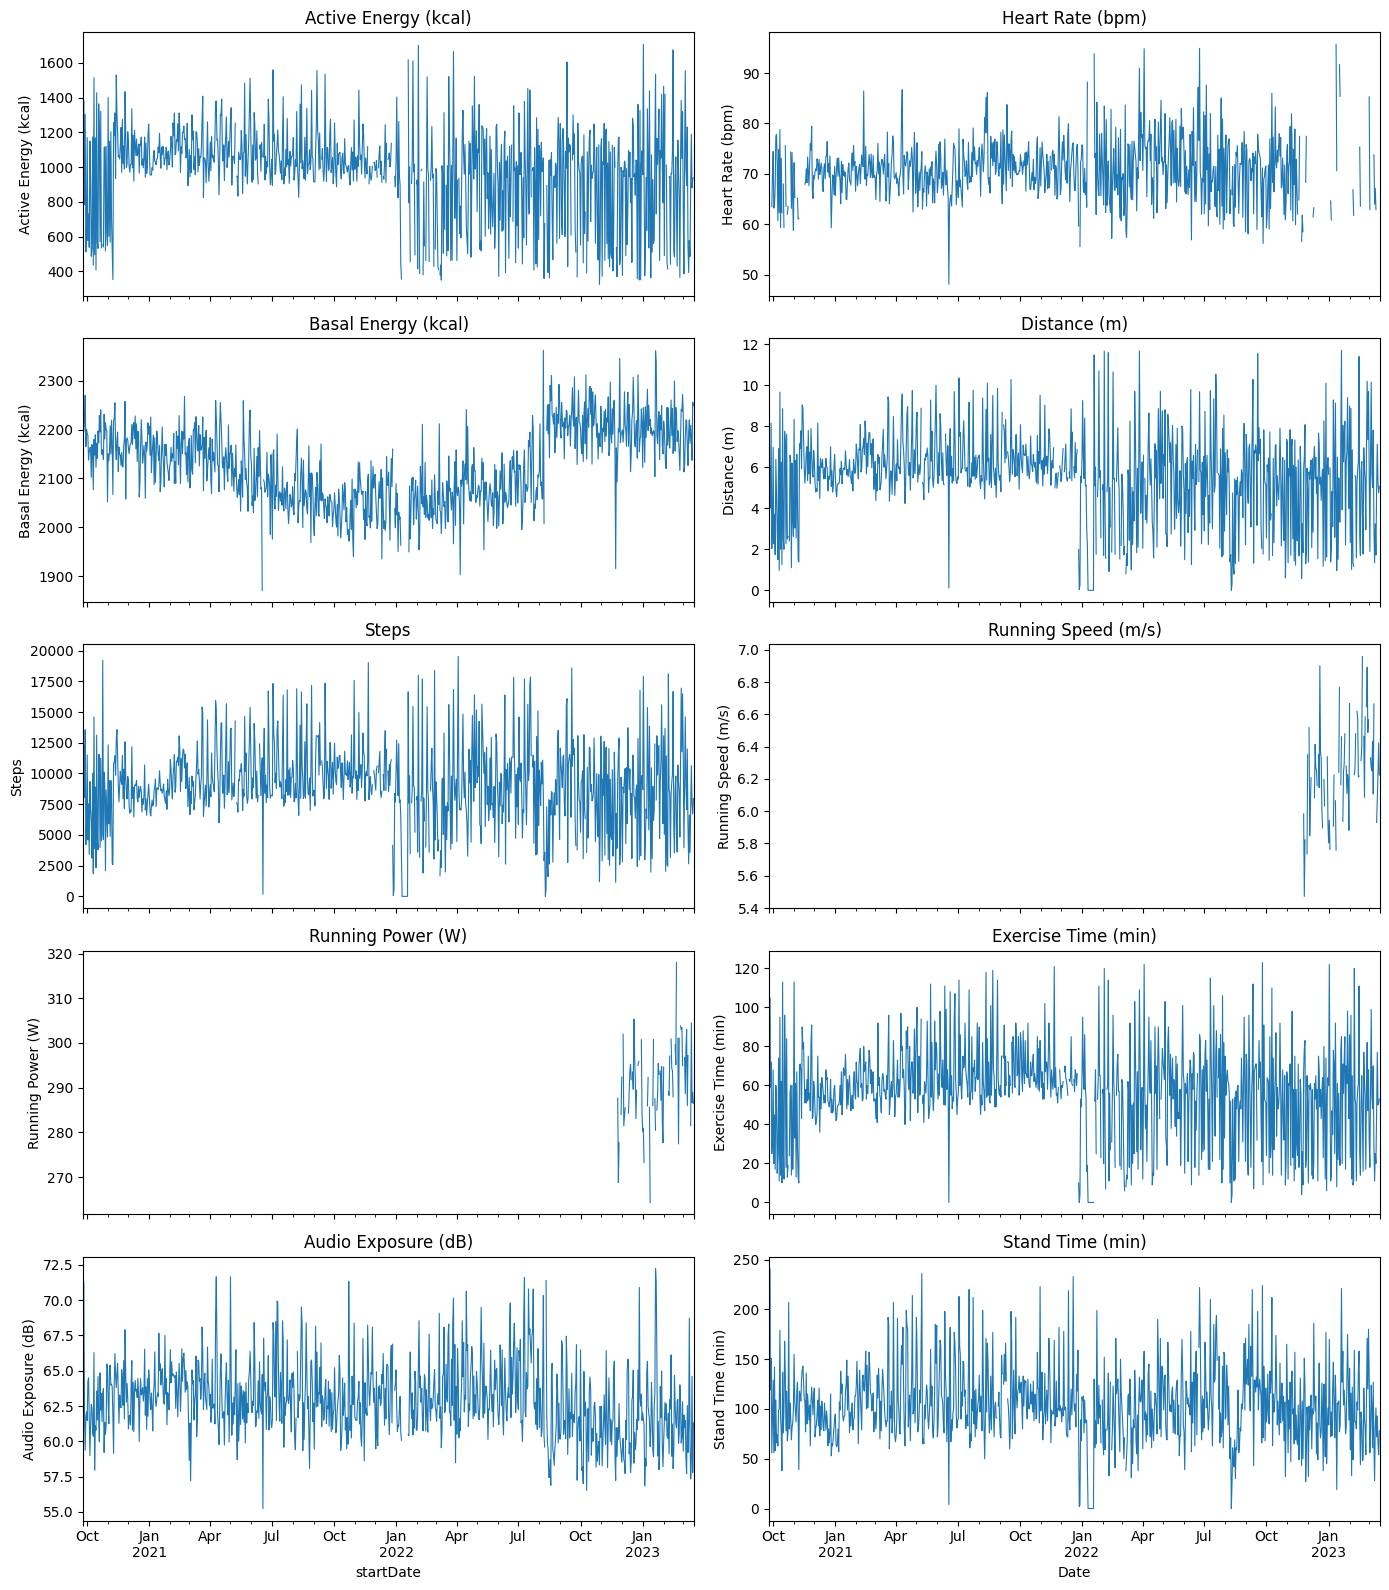

In [52]:
# Create a 5x2 subplot grid with shared x-axis
fig, axes = plt.subplots(5, 2, figsize=(14, 16), sharex=True)
axes = axes.flatten()

# Shorter labels for readability
short_names = {
    'HKQuantityTypeIdentifierActiveEnergyBurned': 'Active Energy (kcal)',
    'HKQuantityTypeIdentifierHeartRate': 'Heart Rate (bpm)',
    'HKQuantityTypeIdentifierBasalEnergyBurned': 'Basal Energy (kcal)',
    'HKQuantityTypeIdentifierDistanceWalkingRunning': 'Distance (m)',
    'HKQuantityTypeIdentifierStepCount': 'Steps',
    'HKQuantityTypeIdentifierRunningSpeed': 'Running Speed (m/s)',
    'HKQuantityTypeIdentifierRunningPower': 'Running Power (W)',
    'HKQuantityTypeIdentifierAppleExerciseTime': 'Exercise Time (min)',
    'HKQuantityTypeIdentifierEnvironmentalAudioExposure': 'Audio Exposure (dB)',
    'HKQuantityTypeIdentifierAppleStandTime': 'Stand Time (min)',
}

for i, col in enumerate(daily_df.columns):
    ax = axes[i]
    daily_df[col].plot(ax=ax, linewidth=0.8)
    ax.set_ylabel(short_names.get(col, col.split('Identifier')[-1]))
    ax.set_title(short_names.get(col, col.split('Identifier')[-1]))

plt.xlabel('Date')
plt.tight_layout()
plt.show()